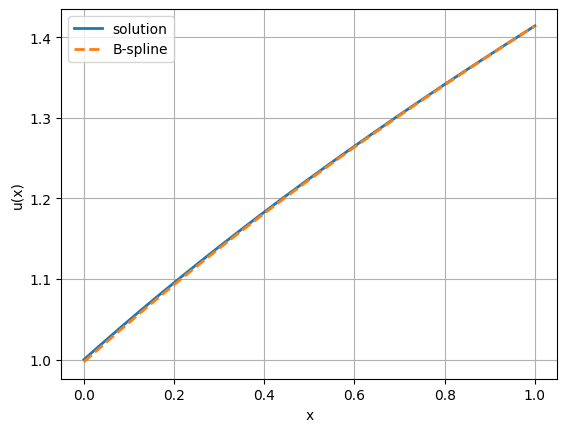

Max absolute error: 2.923e-03


In [3]:
import numpy as np
from scipy.interpolate import BSpline, splev
from scipy.linalg import solve
import matplotlib.pyplot as plt

def u_exact(x):
    return np.sqrt(x + 1)

def du_exact(x):
    return 1 / (2 * np.sqrt(x + 1))

def d2u_exact(x):
    return -1 / (4 * (x + 1)**(3/2))


def f(x):
    return -np.sqrt(x + 1)


degree = 3
n_internal_knots = 2
domain = [0, 1]


knots_internal = np.linspace(domain[0], domain[1], n_internal_knots)
knots = np.concatenate((
    np.repeat(domain[0], degree + 1),
    knots_internal[1:-1],
    np.repeat(domain[1], degree + 1)
))
num_basis = len(knots) - degree - 1


n_collocation_points = num_basis - 2
collocation_points = np.linspace(domain[0], domain[1], n_collocation_points + 2)[1:-1]



def Bspline_basis(i, x):
    coeffs = np.zeros(num_basis)
    coeffs[i] = 1
    spline = BSpline(knots, coeffs, degree)
    return spline(x)

def dBspline_basis(i, x):
    coeffs = np.zeros(num_basis)
    coeffs[i] = 1
    spline = BSpline(knots, coeffs, degree)
    return splev(x, spline.tck, der=1)

def d2Bspline_basis(i, x):
    coeffs = np.zeros(num_basis)
    coeffs[i] = 1
    spline = BSpline(knots, coeffs, degree)
    return splev(x, spline.tck, der=2)


A = np.zeros((num_basis, num_basis))
b_vec = np.zeros(num_basis)

# Уравнения на уравнение (LHS = f(x))
for j, x_j in enumerate(collocation_points):
    for i in range(num_basis):
        A[j, i] = (d2Bspline_basis(i, x_j) +
                   0.5/(x_j + 1) * dBspline_basis(i, x_j) -
                   Bspline_basis(i, x_j))
    b_vec[j] = f(x_j)


for i in range(num_basis):
    A[n_collocation_points, i] = dBspline_basis(i, 0.0)
b_vec[n_collocation_points] = 0.5


for i in range(num_basis):
    A[n_collocation_points + 1, i] = Bspline_basis(i, 1.0)
b_vec[n_collocation_points + 1] = np.sqrt(2)


C = solve(A, b_vec)


def u_approx(x):
    val = np.zeros_like(x)
    for i in range(num_basis):
        val += C[i] * Bspline_basis(i, x)
    return val


x_vals = np.linspace(0, 1, 200)
u_appr = u_approx(x_vals)
u_true = u_exact(x_vals)

plt.plot(x_vals, u_true, label='solution', linewidth=2)
plt.plot(x_vals, u_appr, '--', label='B-spline', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.show()

error = np.max(np.abs(u_appr - u_true))
print(f"Max absolute error: {error:.3e}")